# Analyzing Commits Categories

In [23]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import itertools
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from matplotlib.ticker import PercentFormatter
import ast

In [24]:
df = pd.read_excel('RQ2_coevolution_taxonomy.xlsx', sheet_name='agreement')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   GitAuthor           343 non-null    object
 1   ProjectName         343 non-null    object
 2   CommitID            343 non-null    object
 3   CommitMessage       343 non-null    object
 4   Lsof ModifiedFiles  342 non-null    object
 5   diffPath            338 non-null    object
 6   isPR                342 non-null    object
 7   PRTitle             237 non-null    object
 8   PRDescription       166 non-null    object
 9   Categories          343 non-null    object
 10  TravisCategory      343 non-null    object
dtypes: object(11)
memory usage: 29.6+ KB


In [25]:
def parse_categories(category_string):
    try:
        categories_list = ast.literal_eval(category_string.lower())
        categories_list = list(set(categories_list))
        sorted_categories = sorted(categories_list)
        return sorted_categories
    except (SyntaxError, ValueError):
        print(category_string)
        return []

In [26]:
categories_lists  = df['Categories'].apply(parse_categories).explode()

category_counts = Counter(categories_lists)
category_frequency_dict = dict(category_counts)
category_frequency_dict = {k: v for k, v in sorted(category_frequency_dict.items(), key=lambda item: item[1])}

for i in category_frequency_dict:
    print(f"{i}: {category_frequency_dict[i]}")

data and model versioning: 3
security: 4
deployment: 16
performance optimization: 27
feature development: 49
integration: 56
pipeline automation: 58
model training: 62
code cleanup: 70
refactoring: 76
bug fixing: 88
documentation: 89
dependency management: 207
testing: 214


In [27]:
category_percentage_dict = {k: (v / len(categories_lists)) * 100 for k, v in category_counts.items()}
category_percentage_dict = {k: v for k, v in sorted(category_percentage_dict.items(), key=lambda item: item[1], reverse=True)}

for i in category_percentage_dict:
    print(f"{i}: {category_percentage_dict[i]:.2f}%")

testing: 21.00%
dependency management: 20.31%
documentation: 8.73%
bug fixing: 8.64%
refactoring: 7.46%
code cleanup: 6.87%
model training: 6.08%
pipeline automation: 5.69%
integration: 5.50%
feature development: 4.81%
performance optimization: 2.65%
deployment: 1.57%
security: 0.39%
data and model versioning: 0.29%


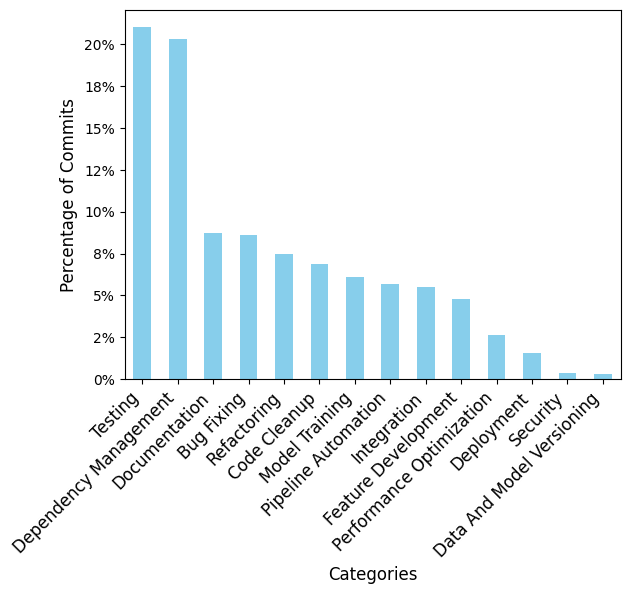

In [28]:
category_df = pd.DataFrame.from_dict(category_percentage_dict, orient='index', columns=['Percentage'])
category_df.index = category_df.index.str.title()

ax = category_df.plot(kind='bar', legend=False, color='skyblue')
ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))
plt.ylabel('Percentage of Commits', fontsize=12)
plt.xlabel('Categories', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
ax.set_facecolor('white')


plt.savefig('rq2_distribution.eps', format='eps', bbox_inches='tight')

plt.show()

In [29]:
category_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['Count'])
category_df.reset_index(inplace=True)
category_df.columns = ['Categories', 'Count']

df['Categories'] = df['Categories'].apply(eval)

category_pairs = []
for categories in df['Categories']:
    pairs = list(itertools.combinations(categories, 2))
    category_pairs.extend(pairs)

# Create a DataFrame with category pairs
pairs_df = pd.DataFrame(category_pairs, columns=['Category1', 'Category2'])

# Count the occurrences of each category pair
category_pair_counts = pairs_df.groupby(['Category1', 'Category2']).size().reset_index(name='Count')

In [30]:
pivot_table = category_pair_counts.pivot_table(index='Category1', columns='Category2', values='Count', fill_value=0)
pivot_table.corr().style.background_gradient(cmap='coolwarm')


Category2,code cleanup,dependency management,deployment,documentation,feature development,integration,model training,performance optimization,pipeline automation,refactoring,security,testing
Category2,,,,,,,,,,,,
code cleanup,1.000000,0.788513,0.119067,0.223979,0.252548,0.092807,0.099938,0.096249,0.004102,0.242069,-0.123091,0.114701
dependency management,0.788513,1.000000,0.220258,0.241350,0.179026,0.186807,0.088115,0.080916,-0.018632,0.246133,-0.184236,0.066971
deployment,0.119067,0.220258,1.000000,0.979989,0.800671,0.923562,0.760925,0.853591,0.780164,0.899550,0.597043,0.814024
documentation,0.223979,0.241350,0.979989,1.000000,0.810446,0.912718,0.747784,0.839249,0.769125,0.886827,0.576606,0.781941
feature development,0.252548,0.179026,0.800671,0.810446,1.000000,0.919416,0.829663,0.866010,0.928806,0.930765,0.455701,0.827535
integration,0.092807,0.186807,0.923562,0.912718,0.919416,1.000000,0.885750,0.909927,0.904575,0.941916,0.502643,0.827558
model training,0.099938,0.088115,0.760925,0.747784,0.829663,0.885750,1.000000,0.934954,0.840481,0.871832,0.387496,0.818136
performance optimization,0.096249,0.080916,0.853591,0.839249,0.866010,0.909927,0.934954,1.000000,0.923280,0.946104,0.450202,0.903192
pipeline automation,0.004102,-0.018632,0.780164,0.769125,0.928806,0.904575,0.840481,0.923280,1.000000,0.913594,0.419612,0.846969


In [31]:
te = TransactionEncoder()
te_ary = te.fit(df['Categories']).transform(df['Categories'])
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(documentation),(dependency management),0.259475,0.603499,0.186589,0.719101,1.191554,0.029996,1.411545,0.217089
1,(pipeline automation),(dependency management),0.169096,0.603499,0.113703,0.672414,1.114193,0.011653,1.210373,0.123347
2,(refactoring),(dependency management),0.221574,0.603499,0.137026,0.618421,1.024727,0.003306,1.039107,0.030998
3,(feature development),(testing),0.142857,0.623907,0.107872,0.755102,1.210280,0.018742,1.535714,0.202703
4,(integration),(testing),0.163265,0.623907,0.116618,0.714286,1.144860,0.014756,1.316327,0.151220
5,(model training),(testing),0.180758,0.623907,0.119534,0.661290,1.059919,0.006757,1.110371,0.069004
6,(pipeline automation),(testing),0.169096,0.623907,0.122449,0.724138,1.160651,0.016949,1.363338,0.166583
7,"(documentation, testing)",(dependency management),0.151603,0.603499,0.104956,0.692308,1.147157,0.013464,1.288630,0.151203


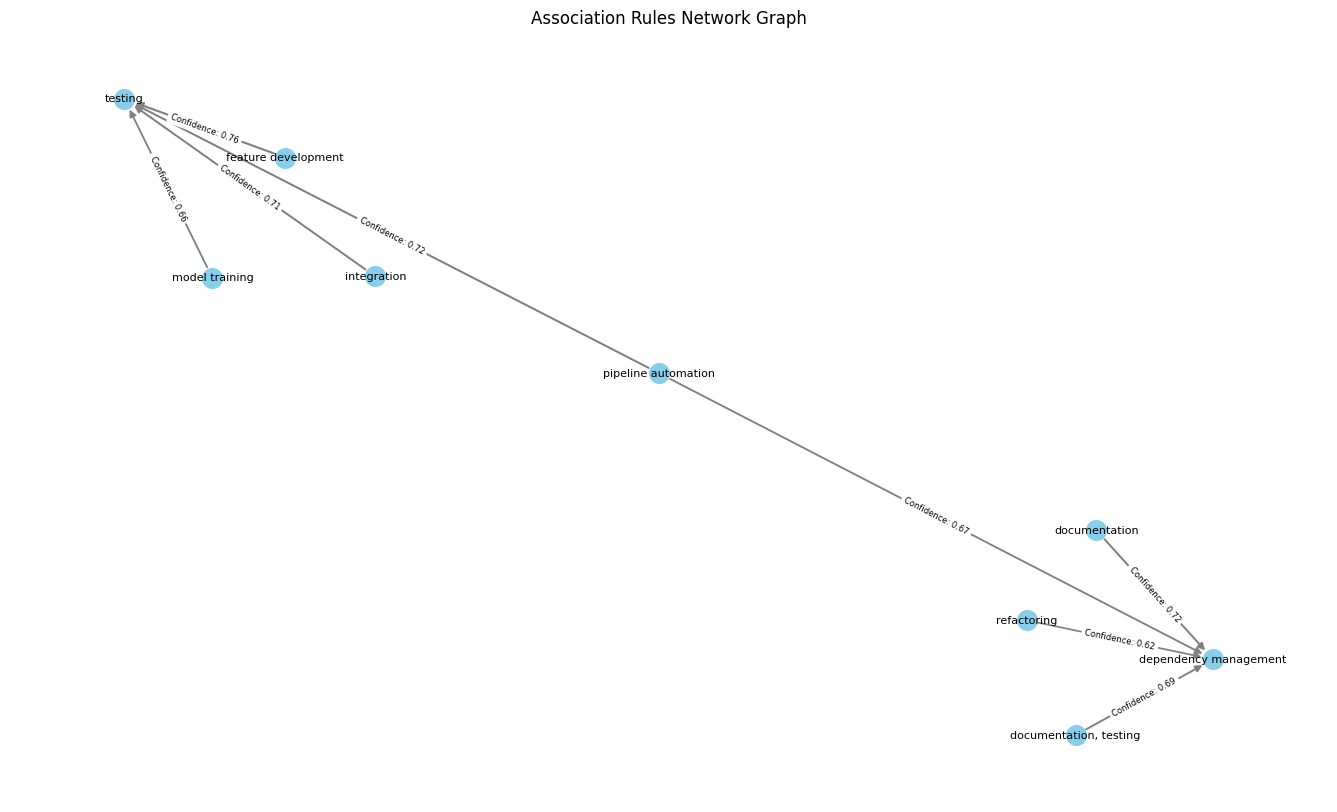

In [32]:
G = nx.DiGraph()
for index, rule in rules.iterrows():
    antecedent = ', '.join(rule['antecedents'])
    consequent = ', '.join(rule['consequents'])
    G.add_edge(antecedent, consequent, weight=rule['confidence'])

# Draw the directed graph with arrows
plt.figure(figsize=(17, 10))
pos = nx.spring_layout(G, seed=42)
labels = {edge: f"Confidence: {G.edges[edge]['weight']:.2f}" for edge in G.edges}
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=[d['weight'] * 2 for u, v, d in G.edges(data=True)], edge_color='gray', arrows=True)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=6)
plt.axis('off')
plt.title('Association Rules Network Graph')
plt.savefig('rq2_arm.eps', format='eps')

plt.show()